## Vlasov equations

We want to solve Vlosov equations on 1  (in $S^1$).

The equations are: 

\begin{align}
\partial_t f + p \partial_x f &= \frac{q}{m}E \partial_p f \\
\partial_t E = -4\pi J \\
\partial_x E = 4\pi \rho \\
\end{align}

Where $f = f(t,x,p)$ is a distribution function in phase espace. 
Note that the invarian volume element is, 

$$
dP = dp_x/p_0
$$ 

We define, the particle number with respect to an observer with four-velocity $u^a$,

$$
N = \int f(x,p)(-u \cdot p)\; dP
$$ 

Thus, for the observer at rest in the coordinate system $(t,x)$ we get

$$
N = \int f(x,p) p_0 \; dP = \int f(x,p) \; dp_x
$$ 

Otherwise one has the four-vector particle density,

$$
N^a = \int f(x,p) p^a \; dP = \int f(x,p) \frac{p^a}{p_0} \; dp_x
$$

Thus, 

$$
N^x = \int f(x,p) \frac{p_x}{p_0} \; dp_x
$$

Likewise we have the energy-momentum tensor,

$$
T^{ab} = \int p^a p^b f(x,p) dP 
$$

So, 

$$
T^{00} = \int p^0 f(x,p) dp_x = m \int \sqrt{1 + p^2/m^2} dp
$$




\begin{align}
\rho(t,x) &:= q\int f(t,x,p) \; dp - n_0 \\
n_0 &:= q \int \int f(t,x,p) \; dp \; dx / V\\
J(t,x) &:= q \int v f(t,x,p) \; dp, \\
v &:= \frac{\frac{p}{m}}{\sqrt{1 + \frac{p^2}{m^2}}} \\ 
\end{align}

And $E = E(t,x)$ is the electric field.


The equilibrium distribution function is: 

$$
f(\gamma) = \frac{\gamma^2 \beta}{\theta K_2(\frac{1}{\theta})}\; e^{-\frac{\gamma}{\theta}} \;\;\;\; \gamma = \frac{1}{\sqrt{1 - \beta^2}}
$$ 

or

$$
f(p) = \frac{1}{4\pi m^3 c^3 \theta K_2(\frac{1}{\theta})} \; e^{-\frac{\gamma(p)}{\theta}} \;\;\;\;\; \gamma(p) = \sqrt{1 + (\frac{p}{m})^2}
$$

and $K_2$ is the Bessel function of second kind.

In [2]:
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using Base.Threads
using Distributions
#Pkg; Pkg.add("DistributedArrays")
println("nthreads = $(nthreads())")

nthreads = 1


In [3]:
include("aux_functions_vlasov.jl")

counter_streams_rel_dist

In [4]:
run_name = "fine_"


landau = false
two_streams = false
landau = true
#two_streams = true
#const Np = 201 # we take even since we need positive and negative values
#const Lx = 1
#const Lp = 0.5 # para cada lado

if landau
    const Lx = 39.738 
    const Nx = 3522
    const Np = 200
    const Lp = 0.5
    run_name = run_name * "landau_"
    α = 0.01
    n = 4
    k = 2*π*n/Lx
    θ = 0.001
    run_name = run_name * "$(Nx)_$(Np)_alp2_n_Th3"
elseif two_streams
    const Nx = 200 # usar par para Fourier transform
    const Lx = 1.0
    const Np = 200
    const Lp = 0.5
    run_name = run_name * "two_streams_"
    k = 2*π*n/Lx
    θ = 0.01
    vel = 0.2
    run_name = run_name * "$(Nx)_$(Np)_vel_p2_n_Th3"
end

dx = Lx/Nx # periodic boundary conditions
dp = 2*Lp/(Np-1) # Dichlet... or whatever but not periodic

const m = 1
const e =-1
#const q = 1

const κ = 2π/Lx



p = [get_p(j,dp,Np)/m for j ∈ 1:Np]
v = [p[j]/sqrt(1+p[j]^2) for j ∈ 1:Np];

run_name


"fine_landau_3522_200_alp2_n_Th3"

In [54]:
#E = zeros(Nx)
#ϕ = zeros(Nx)
ρ = zeros(Nx) #charge density
S = zeros(Nx) #carge current
E_K = zeros(Nx) # kinetic energy
#E_E = zeros(Nx) # Electromagnetic energy
P = zeros(Nx) # Momentum
du = zeros(Nx * (Np+1)); # contains f and E


## Initial data

n0 = -0.2507545687766254
n0 = -1.0000000000000007


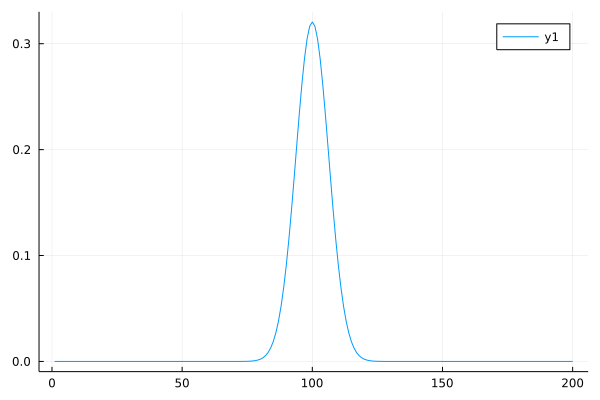

In [55]:
u = zeros(Nx * (Np+1))

pars = (Nx, dx, Lx, Np, dp, Lp, κ, e)



if landau
    pars_f = (m, θ, α, k)
    u = generate_initial_data!(landau_rel_dist, u, pars_f, pars);
elseif two_streams
    pars_f = (m, θ, 0.2)
    u = generate_initial_data!(counter_streams_rel_dist, u, pars_f, pars);
end



F = reshape(u[1:Nx*Np],(Nx,Np));

plot(F[Nx÷2,:])
#plot_matrix(F)
#save("initial_dist_landau_big.png")

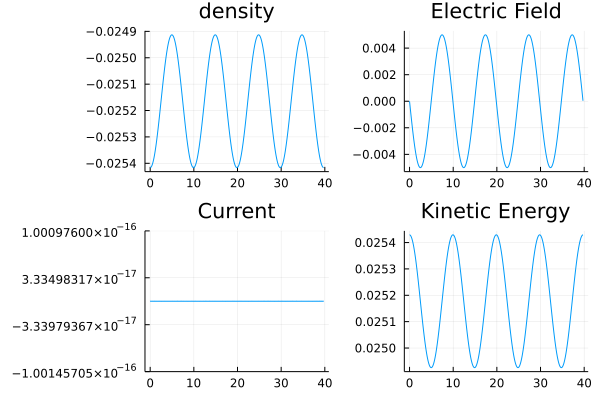

In [56]:
E_i = deepcopy(u[Nx*Np+1:end])
get_current!(u, S, (Nx, dx, Np, dp, v, m, e));
get_density!(u, ρ, (Nx, dx, Np, dp, m, e))
plot(get_K_energy!(u,E_K,(Nx, dx, Np, dp)))

x = [(i-1)*dx for i in 1:Nx]

plot(layout=(2,2))
plot!(subplot=1,x,ρ, title = "density", legend = :false)
plot!(subplot=2,x,E_i, title = "Electric Field", legend = :false)
plot!(subplot=3,x,S, title = "Current", legend = :false)
plot!(subplot=4,x,E_K, title = "Kinetic Energy", legend = :false)

## Time evolution

In [57]:
t = 0.0
t_i = 0.0
t_f = 100.0
M = 10001
M_g = 500 + 1 #number of outputs, starting from the initial data
dt = t_f / (M-1)


0.01

In [58]:
dvx = zeros(Nx)
dvp = zeros(Np)
k1 = zeros(Nx*(Np+1))
k2 = zeros(Nx*(Np+1))
k3 = zeros(Nx*(Np+1))
k4 = zeros(Nx*(Np+1))
p_F = (dx, dp, Nx, Np, v, S, dvx, dvp)
par_RK = (k1, k2, k3, k4)

# total quantities 
Energy_K = zeros(M_g)
Energy_E = zeros(M_g)
EField_T = zeros(M_g)
p_T = zeros(M_g)
n_T = zeros(M_g)
S_T = zeros(M_g)
E_E = 0.0
#T = zeros(M_g)

j = 1

Energy_K[j]  = sum(get_K_energy!(u,E_K,(Nx, dx, Np, dp)))*dx
Energy_E[j]  = get_E_energy(u,(Nx, dx))
EField_T[j] = sum(u[Nx*Np+1:end])*dx
p_T[j] = sum(get_momentum!(u,P,(Nx, dx, Np, dp)))*dx

get_density!(u, ρ, (Nx, dx, Np, dp, m, e))
get_current!(u, S, (Nx, dx, Np, dp, v, m, e))
n_T[j] = get_total_density!(ρ,(Nx, dx))
S_T[j] = sum(S)/n_T[j]/Nx
#T[1] = var(u[N+1:2N])

-3.935069037753216e-22

### Temporal evolution: This takes a while!

In [59]:
#include("aux_functions_vlasov.jl")

for k in 2:M
    RK4_Step!(F!,u,t,dt,p_F,par_RK)
    global t = t + dt
    if (k-1) % (M÷(M_g-1)) == 0
        local j = (k-1)÷(M÷(M_g-1))+1
        Energy_K[j]  = sum(get_K_energy!(u,E_K,(Nx, dx, Np, dp)))*dx
        Energy_E[j]  = get_E_energy(u,(Nx, dx))
        EField_T[j] = sum(u[Nx*Np+1:end])*dx
        p_T[j] = sum(get_momentum!(u,P,(Nx, dx, Np, dp)))*dx
        get_density!(u, ρ, (Nx, dx, Np, dp, m, e))
        get_current!(u, S, (Nx, dx, Np, dp, v, m, e))
        n_T[j] = get_total_density!(ρ,(Nx, dx))
        S_T[j] = sum(S)/n_T[j]/Nx
        println("j = $j , t = $t, k = $k, nthreads = $(nthreads())")
    end
  end

j = 2 , t = 0.20000000000000004, k = 21, nthreads = 1
j = 3 , t = 0.4000000000000002, k = 41, nthreads = 1
j = 4 , t = 0.6000000000000003, k = 61, nthreads = 1
j = 5 , t = 0.8000000000000005, k = 81, nthreads = 1
j = 6 , t = 1.0000000000000007, k = 101, nthreads = 1
j = 7 , t = 1.2000000000000008, k = 121, nthreads = 1
j = 8 , t = 1.400000000000001, k = 141, nthreads = 1
j = 9 , t = 1.6000000000000012, k = 161, nthreads = 1
j = 10 , t = 1.8000000000000014, k = 181, nthreads = 1
j = 11 , t = 2.0000000000000013, k = 201, nthreads = 1
j = 12 , t = 2.199999999999997, k = 221, nthreads = 1
j = 13 , t = 2.399999999999993, k = 241, nthreads = 1
j = 14 , t = 2.5999999999999885, k = 261, nthreads = 1
j = 15 , t = 2.7999999999999843, k = 281, nthreads = 1
j = 16 , t = 2.99999999999998, k = 301, nthreads = 1
j = 17 , t = 3.1999999999999758, k = 321, nthreads = 1
j = 18 , t = 3.3999999999999715, k = 341, nthreads = 1
j = 19 , t = 3.5999999999999672, k = 361, nthreads = 1
j = 20 , t = 3.79999999999

j = 186 , t = 37.00000000000121, k = 3701, nthreads = 1
j = 187 , t = 37.20000000000117, k = 3721, nthreads = 1
j = 188 , t = 37.40000000000113, k = 3741, nthreads = 1
j = 189 , t = 37.60000000000109, k = 3761, nthreads = 1
j = 190 , t = 37.80000000000105, k = 3781, nthreads = 1
j = 191 , t = 38.00000000000101, k = 3801, nthreads = 1
j = 192 , t = 38.20000000000097, k = 3821, nthreads = 1
j = 193 , t = 38.40000000000093, k = 3841, nthreads = 1
j = 194 , t = 38.60000000000089, k = 3861, nthreads = 1
j = 195 , t = 38.80000000000085, k = 3881, nthreads = 1
j = 196 , t = 39.00000000000081, k = 3901, nthreads = 1
j = 197 , t = 39.20000000000077, k = 3921, nthreads = 1
j = 198 , t = 39.40000000000073, k = 3941, nthreads = 1
j = 199 , t = 39.60000000000069, k = 3961, nthreads = 1
j = 200 , t = 39.80000000000065, k = 3981, nthreads = 1
j = 201 , t = 40.00000000000061, k = 4001, nthreads = 1
j = 202 , t = 40.20000000000057, k = 4021, nthreads = 1
j = 203 , t = 40.40000000000053, k = 4041, nthre

j = 369 , t = 73.60000000000075, k = 7361, nthreads = 1
j = 370 , t = 73.80000000000085, k = 7381, nthreads = 1
j = 371 , t = 74.00000000000095, k = 7401, nthreads = 1
j = 372 , t = 74.20000000000105, k = 7421, nthreads = 1
j = 373 , t = 74.40000000000116, k = 7441, nthreads = 1
j = 374 , t = 74.60000000000126, k = 7461, nthreads = 1
j = 375 , t = 74.80000000000136, k = 7481, nthreads = 1
j = 376 , t = 75.00000000000146, k = 7501, nthreads = 1
j = 377 , t = 75.20000000000157, k = 7521, nthreads = 1
j = 378 , t = 75.40000000000167, k = 7541, nthreads = 1
j = 379 , t = 75.60000000000177, k = 7561, nthreads = 1
j = 380 , t = 75.80000000000187, k = 7581, nthreads = 1
j = 381 , t = 76.00000000000198, k = 7601, nthreads = 1
j = 382 , t = 76.20000000000208, k = 7621, nthreads = 1
j = 383 , t = 76.40000000000218, k = 7641, nthreads = 1
j = 384 , t = 76.60000000000228, k = 7661, nthreads = 1
j = 385 , t = 76.80000000000238, k = 7681, nthreads = 1
j = 386 , t = 77.00000000000249, k = 7701, nthre

In [51]:
run = Dict("run_name" => run_name, "p_F" => p_F, "p_Ini" => pars_f, "Energy_E" => Energy_E, "Energy_K" => Energy_K, "E_f" => u[Nx*Np+1:end], "n_F" => ρ, "S_F" => S, "E_T"=> EField_T, "S_T" => S_T, "n_T" => n_T)
#save(run_name * "th$(nthreads())_results.jld2", run)

### Shows the final data, warning lot of  memory for big grids! 

In [60]:
#F = reshape(u[1:Nx*Np],(Nx,Np));
#plot_matrix(F)




n0 = -0.9999999999999986


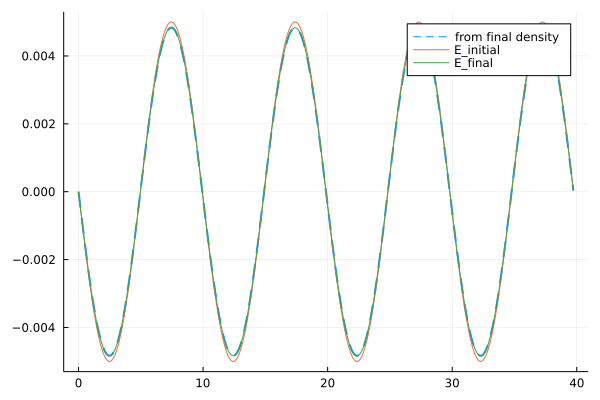

In [61]:
ρ_f = zeros(Nx)
E_f = zeros(Nx)
ϕ_f = zeros(Nx)
S_f = zeros(Nx)


get_density!(u, ρ_f, (Nx, dx, Np, dp, m, e))
n0 = get_total_density!(ρ_f, (Nx, dx))
println("n0 = $(n0)")
get_ϕ!(ϕ_f, ρ_f .- e*n0, κ)
get_E_from_ϕ!(ϕ_f,E_f,dx)


plot(x,E_f,label="from final density", ls=:dash, lw=2)
plot!(x,E_i,label="E_initial")
plot!(x,u[Nx*Np+1:end], label="E_final")
#save("Efield_landau_undamped.png")

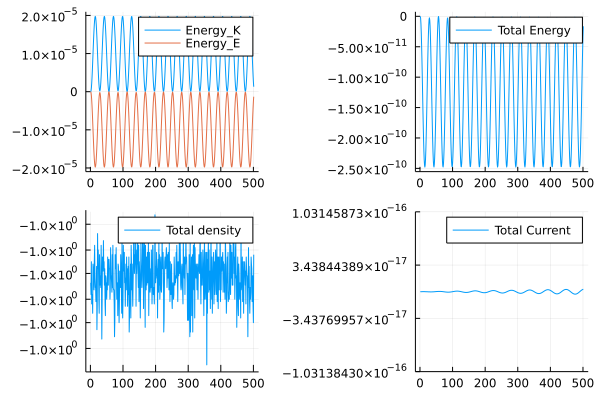

In [62]:
factor = 200
plot(layout=(2,2))
plot!(subplot=1, (Energy_K .- Energy_K[1]), label="Energy_K")
plot!(subplot=1, (Energy_E .- Energy_E[1]), label="Energy_E")
plot!(subplot=2, (Energy_K + Energy_E) ./ (Energy_K[1] + Energy_E[1]) .- 1, label="Total Energy")
plot!(subplot=3, n_T, label="Total density")
plot!(subplot=4, S_T, label="Total Current")
#save("landau_undamped.png")

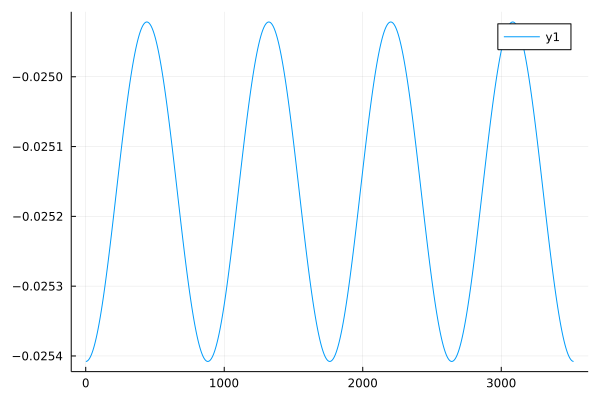

In [63]:
plot(ρ_f)

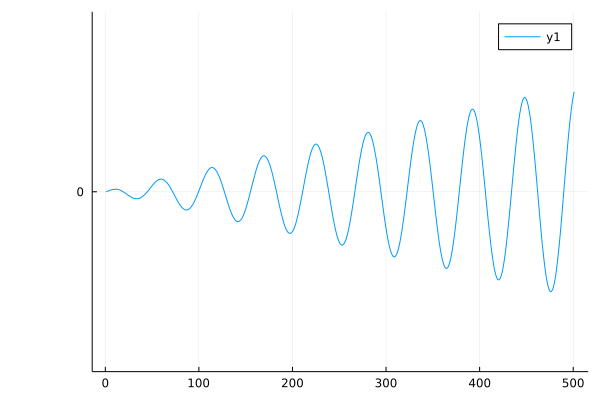

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/reula/.julia/packages/PlotUtils/rTTui/src/ticks.jl:333
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/reula/.julia/packages/PlotUtils/rTTui/src/ticks.jl:333
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/reula/.julia/packages/PlotUtils/rTTui/src/ticks.jl:333
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/reula/.julia/packages/PlotUtils/rTTui/src/ticks.jl:333
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/reula/.julia/packages/PlotUtils/rTTui/src/ticks.jl:333
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/reula/.julia/packages/PlotUtils/rTTui/src/ticks.jl:333
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/reula/.julia/packages/PlotUtils/rTTui/src/ticks.jl:333


In [64]:
plot(p_T)

In [5]:
Energy_K = load(run_name * "th$(nthreads())_results.jld2", "Energy_K")

ArgumentError: ArgumentError: No file exists at given path: fine_landau_3522_200_alp2_n_Th3th1_results.jld2